In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import csv

In [6]:
# pd.set_option('display.max_rows', 100)
# pd.set_option('max_colwidth', 500)
# pd.set_option('display.max_columns', 500)

reviews = pd.read_csv('reviews.csv')
# reviews.head()
df_host = pd.read_csv('listings_cleaned.csv')
# df_host.head(10)

In [9]:
host_filtered = df_host.drop(df_host.iloc[:, 11:59], axis = 1)
host_filtered.head()
# reviews.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,n_bathrooms,shared_private
0,177,https://www.airbnb.com/rooms/177,20210722142814,2021-07-23,Tiny Home in the Heart of the City- ECO FRIENDLY,"160 sq ft + 80 sq ft loft for sleeping, Sleeps...","Quiet neighborhood next to park, creeks and bi...",https://a0.muscache.com/pictures/a1745ab2-b3a0...,615,https://www.airbnb.com/users/show/615,...,4.76,2016-BFN-0004968,f,2,2,0,0,1.49,1.0,private
1,360,https://www.airbnb.com/rooms/360,20210722142814,2021-07-23,Sit in the Peaceful Garden of the Chickadee Co...,Enjoy the famous Colorado weather and unplug i...,The cottage is located in the center of Lower ...,https://a0.muscache.com/pictures/monet/Select-...,666,https://www.airbnb.com/users/show/666,...,4.91,2017-BFN-0002177,f,2,2,0,0,8.98,1.0,private
2,364,https://www.airbnb.com/rooms/364,20210722142814,2021-07-23,Lodo / RiNo LOFT via airport train,"Modern 1,000 square foot loft in the heart of ...","Ten brewpubs within walking distance, two grea...",https://a0.muscache.com/pictures/11766413/a2c5...,783,https://www.airbnb.com/users/show/783,...,4.71,NaN,f,1,1,0,0,0.70,1.5,private
3,590,https://www.airbnb.com/rooms/590,20210722142814,2021-07-23,Comfortable - and a great value!,"Large guest room in my home, where I also live...",I love the diversity of my neighborhood and it...,https://a0.muscache.com/pictures/110931/30991c...,933,https://www.airbnb.com/users/show/933,...,4.84,2021-BFN-0000578,f,2,0,2,0,7.26,1.0,shared
4,592,https://www.airbnb.com/rooms/592,20210722142814,2021-07-23,private,This room is in the basement. It does not hav...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,933,https://www.airbnb.com/users/show/933,...,4.85,2021-BFN-0000578,f,2,0,2,0,1.14,1.0,shared


In [11]:
# host_filtered.drop(['scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'last_review'], axis = 1, inplace = True)
host_filtered.drop(host_filtered.iloc[:, 10:], axis = 1, inplace = True)
host_filtered.head()

,id,listing_url,host_name,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,177,https://www.airbnb.com/rooms/177,Joe,4.80,4.96,4.86,4.96,4.93,4.83,4.76
1,360,https://www.airbnb.com/rooms/360,Jennifer & Giovanni,4.99,4.99,4.96,5.00,5.00,5.00,4.91
2,364,https://www.airbnb.com/rooms/364,Jason,4.85,4.78,4.81,4.95,4.96,4.65,4.71
3,590,https://www.airbnb.com/rooms/590,Jill,4.84,4.76,4.56,4.92,4.95,4.74,4.84
4,592,https://www.airbnb.com/rooms/592,Jill,4.85,4.75,4.55,4.94,4.94,4.80,4.85


In [12]:
#renaming columns for merge on ID/listng ID
reviews.drop(['reviewer_id', 'id'], axis = 1, inplace = True)
reviews.rename(columns = {'listing_id': 'id'}, inplace = True)
reviews.head()

,id,date,reviewer_name,comments
0,177,2016-09-04,Brenna,"Great place to stay! Definitely a tiny home, b..."
1,177,2016-09-13,Rachael,Joe was very friendly and gave us all the info...
2,177,2016-09-14,Haley,Amazing property and Joe was a great host! Eve...
3,177,2016-09-19,Mike,"Joe was a great host, the description of this ..."
4,177,2016-09-22,Carol,He welcomes us when we first arrived and gave ...


In [13]:
df_stars = host_filtered.drop(df_host.iloc[:, 1:2], axis = 1)
df_stars.head(10)

,id,host_name,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,177,Joe,4.80,4.96,4.86,4.96,4.93,4.83,4.76
1,360,Jennifer & Giovanni,4.99,4.99,4.96,5.00,5.00,5.00,4.91
2,364,Jason,4.85,4.78,4.81,4.95,4.96,4.65,4.71
3,590,Jill,4.84,4.76,4.56,4.92,4.95,4.74,4.84
4,592,Jill,4.85,4.75,4.55,4.94,4.94,4.80,4.85
5,686,Alexandra,4.77,4.77,4.81,4.86,4.92,4.87,4.83
6,1940,Joanne,4.93,4.93,4.93,5.00,4.97,4.92,4.88
7,31503,Rick,4.89,4.89,5.00,4.93,4.99,4.86,4.89
8,39405,Jennifer & Giovanni,4.91,4.88,4.93,4.98,4.97,4.84,4.85
9,74125,Joe,4.73,4.80,4.30,4.91,4.97,4.86,4.71


In [14]:
#plot score rating by loc
#if host has multiple listings, take average

#appending price col to host_filtered
price = df_host['price']

host_filtered = host_filtered.join(price)
host_filtered.head()


,id,listing_url,host_name,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
0,177,https://www.airbnb.com/rooms/177,Joe,4.80,4.96,4.86,4.96,4.93,4.83,4.76,99.0
1,360,https://www.airbnb.com/rooms/360,Jennifer & Giovanni,4.99,4.99,4.96,5.00,5.00,5.00,4.91,135.0
2,364,https://www.airbnb.com/rooms/364,Jason,4.85,4.78,4.81,4.95,4.96,4.65,4.71,179.0
3,590,https://www.airbnb.com/rooms/590,Jill,4.84,4.76,4.56,4.92,4.95,4.74,4.84,55.0
4,592,https://www.airbnb.com/rooms/592,Jill,4.85,4.75,4.55,4.94,4.94,4.80,4.85,52.0


In [15]:
df_merged = pd.merge(reviews, host_filtered, on = 'id')
#Removing review scores for this df
df_merged.drop(df_merged.iloc[:, 7:12], axis = 1, inplace = True)
df_merged.head()

,id,date,reviewer_name,comments,listing_url,host_name,review_scores_rating,review_scores_value,price
0,177,2016-09-04,Brenna,"Great place to stay! Definitely a tiny home, b...",https://www.airbnb.com/rooms/177,Joe,4.8,4.76,99.0
1,177,2016-09-13,Rachael,Joe was very friendly and gave us all the info...,https://www.airbnb.com/rooms/177,Joe,4.8,4.76,99.0
2,177,2016-09-14,Haley,Amazing property and Joe was a great host! Eve...,https://www.airbnb.com/rooms/177,Joe,4.8,4.76,99.0
3,177,2016-09-19,Mike,"Joe was a great host, the description of this ...",https://www.airbnb.com/rooms/177,Joe,4.8,4.76,99.0
4,177,2016-09-22,Carol,He welcomes us when we first arrived and gave ...,https://www.airbnb.com/rooms/177,Joe,4.8,4.76,99.0


In [16]:
#Check missing values
df_merged.drop(['review_scores_value'], axis = 1, inplace = True)
df_merged['comments'].isna().sum()

134

In [17]:
import itertools
import collections

#convert text to lowercase
def convert(lst): 
    return ([i for item in lst for i in item.lower().split()]) 

filtered_comments = convert(df_merged['comments'].fillna("")) #Fill in missing reviews with blank


In [18]:
count_word = collections.Counter(filtered_comments) #Count word frequency

clean_word_count = pd.DataFrame(count_word.most_common(5),
                             columns=['words', 'count'])

clean_word_count.head()


,words,count
0,and,427974
1,the,368712
2,to,267911
3,a,256889
4,was,231467


In [19]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/yobae/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
stop_words = set(stopwords.words(['english']))
#View sample set of stopwords
list(stop_words)[0:10]

['because',
 'own',
 'at',
 'her',
 'having',
 'here',
 'each',
 'weren',
 'by',
 'does']

In [21]:
words_review_cleaned = [word for word in filtered_comments if word not in stop_words]
words_review_count = collections.Counter(words_review_cleaned)

word_review_count_df = pd.DataFrame(words_review_count.most_common(15),
                             columns=['words', 'count'])

In [22]:
import matplotlib.pyplot as plt

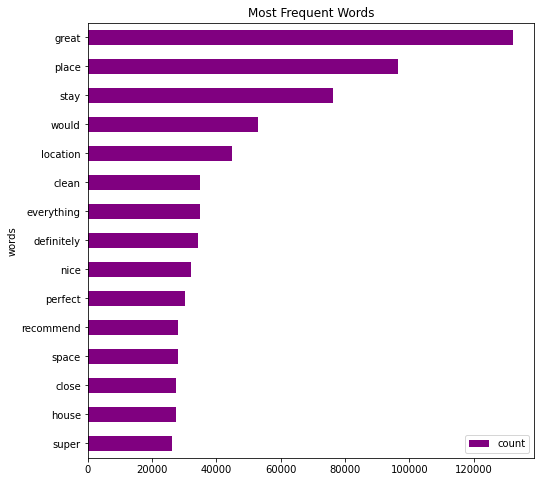

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
word_review_count_df.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Most Frequent Words")

plt.show()

In [24]:
df_merged.shape
df_sample_set = df_merged.iloc[0:100, :]
df_sample_set.head()

,id,date,reviewer_name,comments,listing_url,host_name,review_scores_rating,price
0,177,2016-09-04,Brenna,"Great place to stay! Definitely a tiny home, b...",https://www.airbnb.com/rooms/177,Joe,4.8,99.0
1,177,2016-09-13,Rachael,Joe was very friendly and gave us all the info...,https://www.airbnb.com/rooms/177,Joe,4.8,99.0
2,177,2016-09-14,Haley,Amazing property and Joe was a great host! Eve...,https://www.airbnb.com/rooms/177,Joe,4.8,99.0
3,177,2016-09-19,Mike,"Joe was a great host, the description of this ...",https://www.airbnb.com/rooms/177,Joe,4.8,99.0
4,177,2016-09-22,Carol,He welcomes us when we first arrived and gave ...,https://www.airbnb.com/rooms/177,Joe,4.8,99.0


In [25]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yobae/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [44]:
SIA = SentimentIntensityAnalyzer()
for sentence in df_sample_set['comments'].values[:5]:
    print(sentence)
    ss = SIA.polarity_scores(sentence)
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]), end='')
    print()

Great place to stay! Definitely a tiny home, but still cozy and comfortable. Pretty fun to try it out for a couple nights for the two of us. Joe was helpful and friendly. Destinations were always less than a 20min drive and lots of parks nearby! Super fun stay :)
compound: 0.9918, neg: 0.0, neu: 0.481, pos: 0.519, 
Joe was very friendly and gave us all the information we needed. The house was exactly as described on the site. It was fun and thought provoking experiencing a 100% Eco-friendly space. We plan on staying here again next time we're in Denver!
compound: 0.7419, neg: 0.038, neu: 0.814, pos: 0.148, 
Amazing property and Joe was a great host! Even offered to walk my dog while we were out! Will definitely be back
compound: 0.9039, neg: 0.0, neu: 0.617, pos: 0.383, 
Joe was a great host, the description of this tiny house was spot on.  It was definitely a small space but well laid out and very convenient.  I would recommend a stay there.
compound: 0.8656, neg: 0.0, neu: 0.7, pos: 

positive sentiment: score >= 0.05
neutral sentiment: score > -0.05 and score < 0.05
negative sentiment: score <= -0.05

In [45]:
pscores = [SIA.polarity_scores(comments) for comments in df_sample_set['comments']]

In [46]:
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [47]:
p_stemmer = PorterStemmer()
def stem(sentence):
    tokens = sentence.split()
    stemmed_tokens = [p_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

df_stemwords = df_sample_set[df_sample_set['comments'].notnull()]
df_stemwords['comments'] = df_stemwords['comments'].apply(stem)

In [48]:
from nltk.corpus import stopwords
pd.options.mode.chained_assignment = None
stopwords_list = set(stopwords.words("english"))
#List of punctuation to remove
#Handle html tags?
punctuations = """!()-![]{};:,+'"\,<>./?@#$%^&*_~Â""" 

def reviewParse(comments):
    #Split the review into words
    splitReview = comments.split()
    #Takes punctuation out
    parsedReview = " ".join([word.translate(str.maketrans('', '', punctuations)) + " " for word in splitReview])
    return parsedReview
  
def clean_review(comments):
    #Makes all words lowercase
    clean_words = []
    splitReview = comments.split()
    for w in splitReview:
        if w.isalpha() and w not in stopwords_list:
            clean_words.append(w.lower())
    #Joins split words back into sentence
    clean_review = " ".join(clean_words)
    return clean_review

df_clean = df_stemwords[df_stemwords['comments'].notnull()]
df_clean['comments'] = df_stemwords['comments'].apply(reviewParse).apply(clean_review)

In [49]:
# print(df_clean['comments'])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    100 non-null    int64  
 1   date                  100 non-null    object 
 2   reviewer_name         100 non-null    object 
 3   comments              100 non-null    object 
 4   listing_url           100 non-null    object 
 5   host_name             100 non-null    object 
 6   review_scores_rating  100 non-null    float64
 7   price                 100 non-null    float64
dtypes: float64(2), int64(1), object(5)
memory usage: 7.0+ KB


In [50]:
docs = list(df_clean['comments'])

- tfidf(t, d, D) = tf(t, d) * idf(t, D)
- t = term
- d = document
- D = set of documents
- TF-IDF provides a weight
- This weight is a statistical measure used to evaluate how important 
a word is to a document in a collection or corpus. 
- The importance increases proportionally to the number of times a 
word appears in the document but is offset by the frequency of 
the word in the corpus (data-set).

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer 
 
#Settings for count vectorizer
tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_features = 10000) 
 
#Send all docs here 
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(docs)

In [84]:
pos = [5]
neg = [1, 2]
neu = [3, 4]

def sentiment(rating):
  if rating in pos:
    return 2
  elif rating in neg:
    return 0
  else:
    return 1  

df_clean[['review_scores_rating']] = df_clean[['review_scores_rating']].apply(pd.to_numeric)
df_clean['Sentiment'] = df_clean['review_scores_rating'].apply(sentiment)
df_clean.head(-5)
# print(type(df_clean['review_scores_rating']))
# df_clean.info()

,id,date,reviewer_name,comments,listing_url,host_name,review_scores_rating,price,Sentiment
0,177,2016-09-04,Brenna,great place stay definit tini home still cozi ...,https://www.airbnb.com/rooms/177,Joe,4.80,99.0,1
1,177,2016-09-13,Rachael,joe wa veri friendli gave us inform needed hou...,https://www.airbnb.com/rooms/177,Joe,4.80,99.0,1
2,177,2016-09-14,Haley,amaz properti joe wa great host even offer wal...,https://www.airbnb.com/rooms/177,Joe,4.80,99.0,1
3,177,2016-09-19,Mike,joe wa great host descript thi tini hous wa sp...,https://www.airbnb.com/rooms/177,Joe,4.80,99.0,1
4,177,2016-09-22,Carol,welcom us first arriv gave great recommend din...,https://www.airbnb.com/rooms/177,Joe,4.80,99.0,1
...,...,...,...,...,...,...,...,...,...
90,177,2021-10-10,Dena,veri easy simpl place stay good quick trip,https://www.airbnb.com/rooms/177,Joe,4.80,99.0,1
91,177,2021-10-17,Katie,veri cute tini home heart denver great park space,https://www.airbnb.com/rooms/177,Joe,4.80,99.0,1
92,177,2021-10-24,Victoria,great tini home veri smartli organ space airbn...,https://www.airbnb.com/rooms/177,Joe,4.80,99.0,1
93,360,2018-08-13,Madeleine,thi space wa perfect great location hosts acco...,https://www.airbnb.com/rooms/360,Jennifer & Giovanni,4.99,135.0,1


In [85]:
import plotly.graph_objs as go

In [86]:
fig = go.Figure([go.Bar(x = df_clean.Sentiment.value_counts().index, y = df_clean.Sentiment.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

In [87]:
# tfidf_vectorizer.get_feature_names()
X = tfidf_vectorizer_vectors.toarray()
Y = df_clean['Sentiment'][:5000]

In [88]:
len(X[0])

730

In [89]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix, classification_report, roc_auc_score,roc_curve,auc
from sklearn.tree import DecisionTreeClassifier

#Dividing into train and validation sets

SEED = 123

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = SEED, stratify = Y)

In [90]:
fig = go.Figure([go.Bar(x = Y.value_counts().index, y = Y.value_counts().tolist())])
fig.update_layout(
    title = "Values in each Sentiment",
    xaxis_title = "Sentiment",
    yaxis_title = "Values")
fig.show()

In [91]:
#Decision Tree Classifier
dt = DecisionTreeClassifier(random_state = SEED)
dt.fit(X_train, y_train)
y_pred_test = dt.predict(X_test)
print("Training Accuracy score: " + str(round(accuracy_score(y_train, dt.predict(X_train)), 4)))
print("Testing Accuracy score: " + str(round(accuracy_score(y_test, dt.predict(X_test)), 4)))

Training Accuracy score: 1.0
Testing Accuracy score: 1.0


In [92]:
print(classification_report(y_test, y_pred_test, target_names=['positive', 'neutral', 'negative']))

ValueError: Number of classes, 1, does not match size of target_names, 3. Try specifying the labels parameter

Text(0, 0.5, 'frequency')

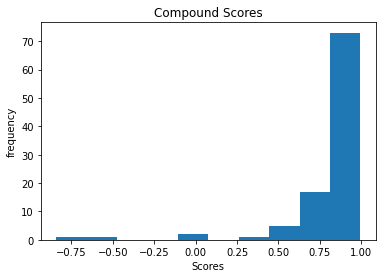

In [79]:
pd.Series([score['compound'] for score in pscores]).plot(kind = 'hist')
plt.title('Compound Scores')
plt.xlabel('Scores')
plt.ylabel('frequency')

Text(0, 0.5, 'Frequency')

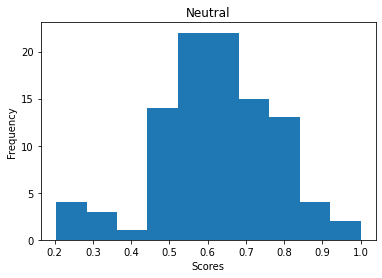

In [80]:
pd.Series([score['neu'] for score in pscores]).plot(kind='hist')
plt.title('Neutral')
plt.xlabel('Scores')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

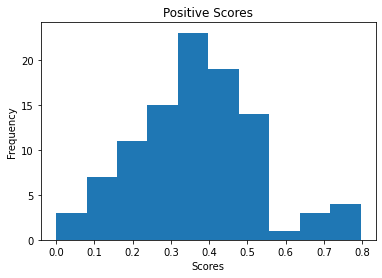

In [81]:
pd.Series([score['pos'] for score in pscores]).plot(kind='hist')
plt.title('Positive Scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

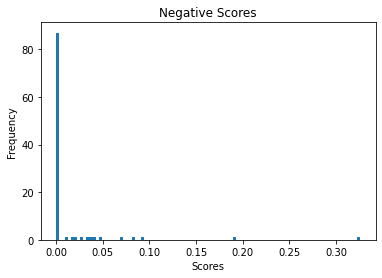

In [82]:
pd.Series([score['neg'] for score in pscores]).plot(kind='hist', bins=100)
plt.title('Negative Scores')
plt.xlabel('Scores')
plt.ylabel('Frequency')

In [60]:
scored_reviews = pd.DataFrame()
scored_reviews['review'] = [r for r in df_sample_set['comments']]
scored_reviews['compound'] = [score['compound'] for score in pscores]
scored_reviews['negativity'] = [score['neg'] for score in pscores]
scored_reviews['neutrality'] = [score['neu'] for score in pscores]
scored_reviews['positivity'] = [score['pos'] for score in pscores]

In [61]:
scored_reviews.query('negativity > 0')

,review,compound,negativity,neutrality,positivity
1,Joe was very friendly and gave us all the info...,0.7419,0.038,0.814,0.148
10,I enjoyed privacy and hospitality during my st...,0.8360,0.041,0.749,0.210
15,This tiny house was wonderful! Joe was excelle...,0.9921,0.034,0.767,0.198
20,This was an experience I would keep doing over...,0.9911,0.012,0.740,0.249
21,"Quaint, cozy setting. The composting toilet is...",-0.5106,0.326,0.538,0.136
22,I booked Joe’s Airbnb for a few days of comple...,0.9845,0.046,0.775,0.179
30,"Joe, as a host, made us very uncomfortable. He...",-0.8425,0.191,0.775,0.034
33,Really enjoyed our stay at the tiny house. It ...,0.8882,0.094,0.597,0.309
61,This was a great place to stop to be refreshed...,0.8930,0.071,0.547,0.382
63,This charming “tiny house” was big enough for ...,0.9860,0.018,0.809,0.173


Not many negative reviews

In [62]:
scored_reviews.iloc[21]['review']
#didn't remove html tags properly

'Quaint, cozy setting. The composting toilet is amazing. No mess, no smell, no fuss, and so much more economical. <br/><br/>'

In [63]:
scored_reviews.query('negativity > positivity').query('negativity > 0.1')

,review,compound,negativity,neutrality,positivity
21,"Quaint, cozy setting. The composting toilet is...",-0.5106,0.326,0.538,0.136
30,"Joe, as a host, made us very uncomfortable. He...",-0.8425,0.191,0.775,0.034


In [64]:
scored_reviews.query('negativity > positivity').query('compound < -0.2')

,review,compound,negativity,neutrality,positivity
21,"Quaint, cozy setting. The composting toilet is...",-0.5106,0.326,0.538,0.136
30,"Joe, as a host, made us very uncomfortable. He...",-0.8425,0.191,0.775,0.034


In [65]:
#TODO: nltk built in sentiment analysis seems to be not as accurate as I'd like
# marking comments negative even though overall sentiment is positive